In [1]:
import boto3

session = boto3.Session(profile_name="default", region_name="us-west-2")

In [2]:
bedrock = session.client("bedrock-runtime")

print(session)
print()

sts = session.client("sts")
identity = sts.get_caller_identity()
print(identity)

Session(region_name='us-west-2')

{'UserId': 'AIDAXB563TTQUDRVBBEHG', 'Account': '485194702049', 'Arn': 'arn:aws:iam::485194702049:user/ilan', 'ResponseMetadata': {'RequestId': '2af072ac-cc52-4d93-86b5-34ac0c89ae05', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2af072ac-cc52-4d93-86b5-34ac0c89ae05', 'content-type': 'text/xml', 'content-length': '401', 'date': 'Sat, 05 Apr 2025 19:26:30 GMT'}, 'RetryAttempts': 0}}


# LLM :

List all foundation models available in Amazon Bedrock

This will print the model IDs of all foundation models

In [34]:
bedrock = session.client("bedrock")

models = bedrock.list_foundation_models()
for model in models['modelSummaries']:
    print(f"Model ID: {model['modelId']}")

Model ID: amazon.titan-tg1-large
Model ID: amazon.titan-embed-g1-text-02
Model ID: amazon.titan-text-lite-v1:0:4k
Model ID: amazon.titan-text-lite-v1
Model ID: amazon.titan-text-express-v1:0:8k
Model ID: amazon.titan-text-express-v1
Model ID: amazon.nova-pro-v1:0
Model ID: amazon.nova-lite-v1:0
Model ID: amazon.nova-micro-v1:0
Model ID: amazon.titan-embed-text-v1:2:8k
Model ID: amazon.titan-embed-text-v1
Model ID: amazon.titan-embed-text-v2:0
Model ID: amazon.titan-embed-image-v1:0
Model ID: amazon.titan-embed-image-v1
Model ID: amazon.titan-image-generator-v1:0
Model ID: amazon.titan-image-generator-v1
Model ID: amazon.titan-image-generator-v2:0
Model ID: amazon.rerank-v1:0
Model ID: stability.stable-diffusion-xl-v1:0
Model ID: stability.stable-diffusion-xl-v1
Model ID: stability.sd3-large-v1:0
Model ID: stability.sd3-5-large-v1:0
Model ID: stability.stable-image-core-v1:0
Model ID: stability.stable-image-core-v1:1
Model ID: stability.stable-image-ultra-v1:0
Model ID: stability.stable

Tester un appel à un LLM :

In [4]:
bedrock = session.client("bedrock-runtime")

# Prompt d'entrée pour le modèle Titan
prompt = {
    "inputText": "Tell me something interesting about neural networks."
}

# Appel au modèle
response = bedrock.invoke_model(
    modelId="amazon.titan-text-express-v1",
    body=bytes(str(prompt).replace("'", '"'), "utf-8"),
    contentType="application/json",
    accept="application/json"
)

# Affichage du résultat
print(response["body"].read().decode())

{"inputTextTokenCount":8,"results":[{"tokenCount":113,"outputText":"\nNeural networks are computer systems that are modeled after the human brain and can learn and adapt like humans. Neural networks are built from artificial neurons that can process information using mathematical operations. They are used in many applications, such as image recognition, natural language processing, and autonomous vehicles. Neural networks are trained using large amounts of data and can be used to make predictions or decisions. They are also used in robotics and medical imaging. Neural networks are complex systems that can be difficult to understand and train, but they have the potential to revolutionize many industries.","completionReason":"FINISH"}]}


# Connection avec la base de données (S3 et Redshift) :

In [5]:
pip install redshift-connector

Note: you may need to restart the kernel to use updated packages.


Vérifier que la connection marche :

In [12]:
import boto3

# Initialisation du client Redshift Data
client = boto3.client('redshift-data', region_name='us-west-2')

# Paramètres de connexion
database = 'dev'
workgroup_name = 'redshift-wg-hackathon'

# Requête de test
sql_query = 'SELECT current_date;'

try:
    response = client.execute_statement(
        Database=database,
        WorkgroupName=workgroup_name, 
        Sql=sql_query
    )
    print("✅ Connexion réussie !")
    print("Statement ID :", response["Id"])
except Exception as e:
    print(f"❌ Erreur de connexion : {e}")

✅ Connexion réussie !
Statement ID : a2ae7c98-66c7-4e43-89e8-a261a8d3dce0


In [6]:
import pandas as pd
import time

def run_sql_and_show(query):
    try:
        response = client.execute_statement(
            Database=database,
            WorkgroupName=workgroup_name,
            Sql=query
        )
        statement_id = response["Id"]

        while True:
            status = client.describe_statement(Id=statement_id)
            if status["Status"] in ["FINISHED", "FAILED", "ABORTED"]:
                break
            time.sleep(1)

        if status["Status"] == "FINISHED":
            results = client.get_statement_result(Id=statement_id)
            columns = [col["name"] for col in results["ColumnMetadata"]]
            rows = [
                [field.get("stringValue", "") for field in record]
                for record in results["Records"]
            ]
            df = pd.DataFrame(rows, columns=columns)
            display(df)  # joli tableau dans Jupyter
        else:
            print("❌ Erreur :", status["Error"])
    except Exception as e:
        print("❌ Exception :", e)

C:\Users\zinii\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Ce code sert à :

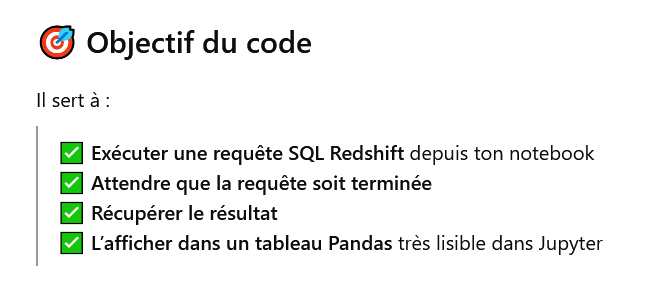

In [7]:
import boto3
import time

client = boto3.client('redshift-data', region_name='us-west-2')
database = 'dev'
workgroup_name = 'redshift-wg-hackathon'

def run_sql_and_fetch(query):
    try:
        response = client.execute_statement(
            Database=database,
            WorkgroupName=workgroup_name,
            Sql=query
        )
        statement_id = response["Id"]
        while True:
            status = client.describe_statement(Id=statement_id)
            if status["Status"] in ["FINISHED", "FAILED", "ABORTED"]:
                break
            time.sleep(1)

        if status["Status"] == "FINISHED":
            print("✅ Requête exécutée avec succès.")
        else:
            print("❌ Erreur :", status["Error"])
    except Exception as e:
        print("❌ Exception :", e)

Ce code sert à :

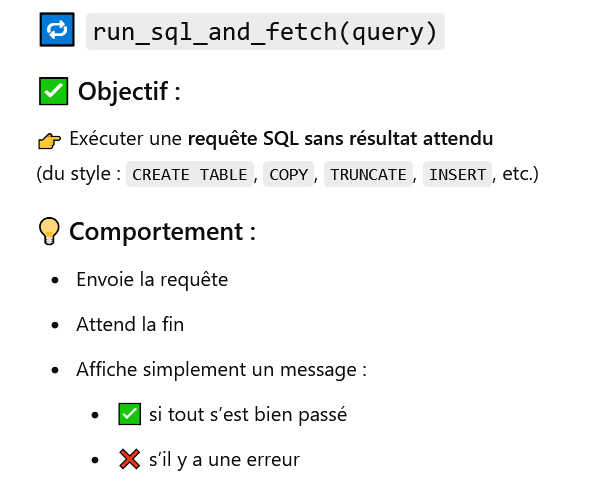

Nos tables dans Redshift :

Création de la table clients_database :

In [46]:
create_table = """
CREATE TABLE clients_database (
    Client_ID NUMERIC,
    Auto_Insurance_Contract NUMERIC,
    Health_Insurance_Contract NUMERIC,
    Home_Insurance_Contract NUMERIC,
    Life_Insurance_Contract NUMERIC,
    Coverage_Amount NUMERIC,
    Assurance_Cost_Per_Month NUMERIC,
    Creditworthiness VARCHAR(255),
    Claims_History_Count NUMERIC,
    Last_Reported_Claim_Type VARCHAR(255),
    Last_Reported_Claim_Date DATE,
    Last_Claim_Resolution_Type VARCHAR(255),
    Claim_Rate DECIMAL(10, 2),
    Customer_Tenure_Years NUMERIC,
    Is_Premium_Client NUMERIC,
    Health_History VARCHAR(255),
    Risk_Profile VARCHAR(255),
    Recent_Life_Event VARCHAR(255),
    Recent_Life_Event_Date DATE,
    Age NUMERIC,
    Annual_Income NUMERIC,
    Employment_Status VARCHAR(255),
    Has_Kids NUMERIC,
    Homeownership_Status VARCHAR(255),
    Type_of_Housing VARCHAR(255),
    Has_Car NUMERIC,
    Location VARCHAR(255),
    Primary_Transportation_Mode VARCHAR(255),
    Last_Interaction_Date DATE,
    Last_Contract_Change_Date NUMERIC,
    Last_Account_Update NUMERIC
);
"""

run_sql_and_fetch(create_table)


✅ Requête exécutée avec succès.


Importer les données de notre fichier data_final.csv (stocké dans S3), dans notre table clients_database dans Redshift :

In [47]:
copy_query = """
COPY clients_database
FROM 's3://s3-bucket-eika/data_final.csv'
IAM_ROLE 'arn:aws:iam::485194702049:role/service-role/AmazonRedshift-CommandsAccessRole-20250405T172656'
FORMAT AS CSV
IGNOREHEADER 1
EMPTYASNULL
DATEFORMAT AS 'DD/MM/YYYY';
"""

run_sql_and_fetch(copy_query)

✅ Requête exécutée avec succès.


Vérifier que ca a marché :

In [62]:
run_sql_and_show("SELECT * FROM clients_database order by client_id;")

,client_id,auto_insurance_contract,health_insurance_contract,home_insurance_contract,life_insurance_contract,coverage_amount,assurance_cost_per_month,creditworthiness,claims_history_count,last_reported_claim_type,...,employment_status,has_kids,homeownership_status,type_of_housing,has_car,location,primary_transportation_mode,last_interaction_date,last_contract_change_date,last_account_update
0,1,1,0,1,1,52004,225,Excellent,0,,...,Unemployed,1,Own,Apartment,1,Urban,Public transportation,2024-02-07,212,0
1,2,1,1,0,1,48660,858,Excellent,0,,...,Unemployed,0,Own,Apartment,0,Urban,Biking,2024-02-17,280,0
2,3,0,1,1,0,42672,259,Average,4,Damage,...,Remote,1,Own,Single-family home,0,Urban,Car,2023-04-06,153,0
3,4,0,1,1,0,89407,825,Poor,0,,...,Remote,1,Own,Apartment,0,Urban,Car,2024-06-14,459,0
4,5,1,1,1,0,92453,451,Excellent,3,Accident,...,Unemployed,1,Own,Townhouse,0,Urban,Walking,2025-02-15,383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1,0,0,0,75208,933,Excellent,4,Accident,...,Hybrid,0,Own,Townhouse,0,Suburban,Car,2023-05-08,393,0
9996,9997,0,0,1,1,83216,940,Good,2,Theft,...,Unemployed,1,Own,Single-family home,0,Urban,Biking,2023-06-20,119,0
9997,9998,0,0,1,0,95967,403,Excellent,4,Theft,...,Unemployed,1,Own,Single-family home,0,Urban,Public transportation,2024-10-02,176,0
9998,9999,1,0,1,0,59336,151,Excellent,0,,...,Unemployed,0,Own,Single-family home,0,Urban,Biking,2023-12-26,150,0


In [59]:
run_sql_and_fetch("""
ALTER TABLE clients_database DROP COLUMN client_id;

ALTER TABLE clients_database ADD COLUMN client_id NUMBER;

UPDATE clients_database
SET client_id = sub.new_id
FROM (
    SELECT ROW_NUMBER() OVER (ORDER BY true) AS new_id,
           ctid
    FROM clients_database
) AS sub
WHERE clients_database.ctid = sub.ctid;
""")


❌ Erreur : ERROR: cannot drop sortkey column "client_id"


In [60]:
run_sql_and_show("""
SELECT tablename
FROM pg_table_def
WHERE schemaname = 'public'
GROUP BY tablename
ORDER BY tablename;
""")

,tablename
0,clients_database


In [50]:
run_sql_and_fetch("DROP TABLE IF EXISTS clients_database2;")

✅ Requête exécutée avec succès.


In [ ]:
import boto3
import time

# Config Redshift
redshift_client = boto3.client("redshift-data", region_name="us-west-2")
DATABASE = "dev"
WORKGROUP = "redshift-wg-hackathon"

# Commande SQL à exécuter
sql_query = "GRANT SELECT ON ALL TABLES IN SCHEMA public TO PUBLIC;"

# Envoi de la requête
response = redshift_client.execute_statement(
    Database=DATABASE,
    WorkgroupName=WORKGROUP,
    Sql=sql_query
)

# Attente du résultat
statement_id = response['Id']
print(f"Statement ID: {statement_id}")

# Attendre l'exécution
while True:
    status = redshift_client.describe_statement(Id=statement_id)["Status"]
    if status in ["FINISHED", "FAILED", "ABORTED"]:
        break
    time.sleep(2)

# Vérification du statut
if status == "FINISHED":
    print("Droits SQL GRANT exécutés avec succès.")
else:
    print(f"Erreur durant l'exécution: {status}")

Statement ID: b32a0b9c-2c73-404d-9653-df08a7f229be
✅ Droits SQL GRANT exécutés avec succès.
